# Movie Rating Prediction
###  --ECE 532 Honor Project

#### Student: Huanran Li (hli488@wisc.edu)
#### Advised by Professor: Matthew Malloy

### Table of Contents

1. [Introduction](#1.-Introduction)
2. [File Input & Dict Creation](#2.-File-Input-and-Dict-Creation)
3. [Principal component analysis (PCA) on user/movie ratings matrix](#3.-Principal-component-analysis-(PCA)-on-user/movie-ratings-matrix)
4. [Average Movie Score Prediction](#4.-Average-Movie-Score-Prediction)
    1. [Least Square Fit](#4.A-Least-Square-Fit)
    2. [Least Square with Ridge Regression](#4.B-Least-Square-with-Ridge-Regression)
    3. [Least Square with Truncated SVD](#4.C-Least-Square-with-Truncated-SVD)
5. [Single User's Movie Rating Prediction](#5.-Single-User's-Movie-Rating-Prediction)
    1. [Linear Least Square Fit](#5.A-Linear-Least-Square-Fit)
    2. [High Dimension Least Square Fit with L2 regularization](#5.B-High-Dimension-Least-Square-Fit-with-L2-regularization)
6. [Discussion](#6.-Discussion)
    1. [Average Rating Prediction](#6.A-Average-Rating-Prediction)
    2. [User's Rating Prediction](#6.B-User's-Rating-Prediction)
7. [Conclusion](#7.-Conclusion)

## 1. Introduction ##

This Project was based on the dataset found on Kaggle, which has over 20M movie ratings and tagging activity since 1995. Dataset can be found at: https://www.kaggle.com/grouplens/movielens-20m-dataset.

From the rating and tags, this project aimed to predict the movie's rating score based on its tags and the user's past rating record. To achieve this, the project would be split into three parts. 

The first part was going to analyze the relationship between the user's rating and tags of a movie by PCA. The sparse matrix was implemented due to the large size of the rating matrix. Then the movie with the high scores in the singular vectors would be selected and its tags would be counted. In this way, the pattern could be revealed by showing the most common tags that the selected movies all had.

The second part performed a linear least square regression with 2 types of regularization to find the relationship between the average movie ratings and tags' percentage. From the model we trained, we could effectively predict a movie's average rating (from 1 to 5) based on the the movie's tags.

The third part was able to predict a single user's movie rating scores based on this user's past rating record on other movies. This was done by fitting a LS regression between the user's past score record and the left singular vectors from the rating sparse matrix. In this part, two regression methods were implemented, which were linear least square and Gaussian Kernel LS regression.

In [2]:
import time
import random
import numpy as np
import scipy
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds, eigs
import matplotlib.pyplot as plt
import math

##  2. File Input and Dict Creation##
This part contained all the necessary methods to read data from files and create the corresponding dict or list.
After this section, the following data structures were going to created based on the input file.


### 1. rating[  ]

| UserID        | MovieID|Rating          |
| ------------- |:-------------:| --------:|
|0|0| 3.5|
|1|3| 4.5|
|..|..|..|


In [ ]:
import csv
import time

start_time = time.time()
rating = []

#reading the data with the row structure: [userid, movieid, rating]
with open('rating.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        rating.append(row[0:3])

#delete the first row with title
rating = rating[1:]

np.savetxt('rating_data.txt', rating, fmt = '%s')

print("Time taken: ", (time.time() - start_time))

In [5]:
start_time = time.time()
rating = np.loadtxt('rating_data.txt', dtype = str)
print("Time taken: ", (time.time() - start_time))

Time taken:  173.77225255966187


In [15]:
sample_rating = rating[:].copy()

#transfer a double list to a matrix so that we could use [tuple] for indexing, like [1:2,:]
temp = []
for row in sample_rating:
    temp.append([int(row[0]),int(row[1]),float(row[2])])
temp = np.asarray(temp)
sample_rating = temp
print("rating shape: ", sample_rating.shape)

rating shape:  (20000263, 3)


### 2. movie_tag_score_list{  }

| MovieID        | MovieTags{  }          |
| ------------- |--------:|
|0|movie_tags{ }|
|1|movie_tags{ }|
|..|..|..|

#### where movie_tags{  } were:

| TagID        | Tag Score          |
| ------------- |--------:|
|1| 0.025|
|2|0.025|
|3|0.05775|
|..|..|..|



In [3]:
import csv
import time

#dict container structure: movie_tag_score_list[movie_id] = movie_tag{tag_id: tag_score}
movie_tag_score_list = {}
start_time = time.time()

#reading the data with the row structure: [movie_id, tag_id, tag_score]
with open("genome_scores.csv") as csvfile:
    readCSV = csv.reader(csvfile, delimiter = ',')
    movie_id = 1
    movie_tag = {}
    for row in readCSV:
        movie_id_new = row[0]
        if(movie_id_new == 'movieId'):
            continue
        else:
            movie_id_new = int(movie_id_new)
            
        if(movie_id == movie_id_new):
            movie_tag[int(row[1])] = float(row[2])
        else:
            movie_tag_score_list[movie_id] = movie_tag
            movie_tag = {}
            movie_id = movie_id_new
            
print("Time taken: ", (time.time() - start_time))


Time taken:  12.343984365463257


### 3. tag_list{  }:

| TagID        | Tag Name          |
| ------------- |--------:|
|1| 007|
|2|007 (series)|
|3|18th century|
|..|..|


In [4]:
#dict container structure: tag_list[tag_id] = tag_name
tag_list = {}

with open("genome_tags.csv") as csvfile:
    readCSV = csv.reader(csvfile, delimiter = ',')
    for row in readCSV:
        if (row[0] == 'tagId'):
            continue
        tag_list[int(row[0])] = row[1]

### 4.  user_dict{  }:

| UserID (discontinuous)        | User_index (continuous)      | 
| ------------- |--------:|
|1| 0|
|2|1|
|3|2|
|..|..|


In [7]:
#relable all the users with dict structure: user_dict[user_id] = user_index
user_dict = dict.fromkeys([row[0] for row in sample_rating])
cnt = 0
for row in user_dict:
    user_dict[row] = cnt
    cnt += 1


### 5.  movie_dict{  }:

| MovieID (discontinuous)       | Movie_index (continuous)|    
| ------------- |--------:|
|1| 0|
|4|1|
|8|2|
|10|3|
|..|..|

In [8]:
#relabel all the movie with dict structure: movie_dict[movie_id] = movie_index
movie_dict = dict.fromkeys([row[1] for row in sample_rating])

cnt = 0
for row in movie_dict:
    movie_dict[row] = cnt
    cnt += 1

In [19]:
print("Total # of ratings: ", sample_rating.shape[0])
print("Total # of users found: ", len(user_dict))
print("Total # of movies found: ", len(movie_dict))
print("Filling Rate: ", sample_rating.shape[0]/ len(user_dict) / len(movie_dict) )

Total # of ratings:  20000263
Total # of users found:  138493
Total # of movies found:  26744
Filling Rate:  0.00539984781355445


## 3. Principal component analysis (PCA) on user/movie ratings matrix##

In order to perform PCA, we constructed a matrix which contained all movie ratings from every user in the following structure. If the user did not rating a specific movie, that score would result in 0.

|_ |Movie_0| Movie_1|Movie_2|...|Movie_26744|    
| -------------:|--------:| -------------:|--------:|-------------:|--------:|
|User_0 |3.5 |3.5 |4.5|...|4|
|User_1 |0 |0 |0|...|3|
|User_2 |0 |1 |0|...|1.5|
|... |... |... |...|...|...|
|User_138493 |0 |0 |0|...|0|

The matrix size: $ \#users * \#movies = 3.7G $  
Amount of ratings: $ \#ratings = 20M $  
The matrix filling rate: $$\frac{\#ratings }{\#users * \#movies}  = 0.5\% $$

Due to the large size and sparsity of the matrix, I decided to reconstruct the data structure into a sparse matrix in the coordinate form.

| User_index        | Movie_index  |Rating          |
| ------------- |:-------------:| --------:|
|0|0| 3.5|
|1|0| 4.5|
|..|..|..|



### Step 1: Sparse Matrix Creation and Mean Removal

In [10]:
#construct the sparse Matrix
rating_number = sample_rating[:,2]
col_index = [user_dict[i] for i in sample_rating[:,0]]
row_index = [movie_dict[i] for i in sample_rating[:,1]]

sp_matrix = scipy.sparse.coo_matrix((rating_number, (row_index, col_index)), shape = (len(movie_dict), len(user_dict)))

In [39]:
#find the total of each row
rolsum = scipy.sparse.coo_matrix.sum(sp_matrix, axis = 1)
start_time = time.time()
print(rolsum.shape)
for i in range(rolsum.shape[0]):
    row = sp_matrix.getrow(i)
    nonzero = row.getnnz()
    rolsum[i] = rolsum[i]/nonzero
    if(i % 10000 == 0): #around 1 h
        print("At data index ",i, "; Time taken: ", (time.time() - start_time) / 3600 , "hours")

(26744, 1)
At data index  0 ; Time taken:  0.00010749505625830757 hours
At data index  10000 ; Time taken:  1.0578165900707246 hours
At data index  20000 ; Time taken:  2.096303464240498 hours


In [40]:
#construct the sparse matrix with every row's mean = 0
zero_mean_sample = sample_rating.copy()

for i in range(len(zero_mean_sample)):
    zero_mean_sample[i][2] = zero_mean_sample[i][2] - rolsum[ movie_dict[zero_mean_sample[i][1]] , 0]
    
rating_number_z = zero_mean_sample[:,2]
col_index_z = [user_dict[i] for i in zero_mean_sample[:,0]]
row_index_z = [movie_dict[i] for i in zero_mean_sample[:,1]]

sp_matrix_zero = scipy.sparse.coo_matrix((rating_number_z, (row_index_z, col_index_z)), shape = (len(movie_dict), len(user_dict)))

In [41]:
#zero mean test
movie_mean = scipy.sparse.coo_matrix.mean(sp_matrix_zero, axis = 1)
print("Mean of the zero_mean matrix: ", movie_mean)

Mean of the zero_mean matrix:  [[5.20010467e-17]
 [7.58623883e-20]
 [2.34462108e-16]
 ...
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]


In [42]:
print("Zero mean matrix: ", sp_matrix_zero)

Zero mean matrix:    (0, 0)	0.2880231983095807
  (1, 0)	-0.4522300469483569
  (2, 0)	-0.39805469097376633
  (3, 0)	-0.5534925663021113
  (4, 0)	-0.8343722078032592
  (5, 0)	0.08742640874684593
  (6, 0)	0.46096227013316415
  (7, 0)	0.13044946191179552
  (8, 0)	0.5033553395240857
  (9, 0)	-0.19067190194855232
  (10, 0)	-0.0505735544876762
  (11, 0)	-0.17423116921705528
  (12, 0)	-0.4469904996370291
  (13, 0)	-0.25583021083832014
  (14, 0)	0.3252821079571895
  (15, 0)	-0.13370569350717432
  (16, 0)	-0.4319539085828037
  (17, 0)	-0.6770565095815098
  (18, 0)	-0.21684751972942484
  (19, 0)	-0.4816805288974195
  (20, 0)	-0.4557478319407595
  (21, 0)	0.3623271889400921
  (22, 0)	0.06615349189118058
  (23, 0)	0.15037613093422797
  (24, 0)	-0.4811256506299557
  :	:
  (1944, 138492)	0.5477787091366304
  (2603, 138492)	0.04247910863509752
  (971, 138492)	-0.39443625644804703
  (1945, 138492)	0.5076782925559606
  (972, 138492)	1.1527428283844992
  (974, 138492)	1.177877824858757
  (1953, 138492)	1

### Step 2: Movie Score Contribution Analysis by PCA ###
This section was done in several steps: 

1. Found the principal components from svd on the mean-removed sparse matrix.  
2. Created a movie set by picking the movies with large values from a given principal component.
3. Count the tag appearance from the top 5 tags of each movie
4. Printed the first 5 tags and their appearances.
5. Plot the graph of all tags counted.


In [28]:
def u_movie_analysis(u_index, u, top_tags_number):
    #find the same format of information for the u_index'th singular vector
    u_single = u[:,u_index]
    u_single_dict = {}
    for i in range(len(u_single)):
        if(u_single[i] > 0):
            u_single_dict[i] = u_single[i]

    #tag count
    tag_cnt = {}

    #find the tag of these movie favored by the first taste vector u[0]
    for movie_index in u_single_dict:
        #find the key based on the value
        movie_id = list(movie_dict.keys())[list(movie_dict.values()).index(movie_index)]

        #get the list of tag:percentage based on that movie
        if(movie_id not in movie_tag_score_list):
            print("movie id ", movie_id, "NOT found in tags_scores_list")
            continue
        scores = movie_tag_score_list[movie_id]

        #pick the first top_tag_number tags of each movie
        rank_list = sorted(scores, key=scores.get, reverse=True)
        top = rank_list[0:top_tags_number]
        top_dict = {i: tag_list[i] for i in top}

        #count the tags for each movie
        for item in top_dict:
            if item in tag_cnt:
                tag_cnt[item] += 1
            else:
                tag_cnt[item] = 1

    sorted_list = sorted(tag_cnt, key=tag_cnt.get, reverse=True)
    tag_ranked = {i: tag_cnt[i] for i in sorted_list}
    return tag_ranked


In [29]:
def output_result(u_index, u, top_tags_number = 10, top_print_number = 5, print_graph = True):
    tag_ranked = u_movie_analysis(u_index, u, top_tags_number)
    cnt = 0
    for movie in tag_ranked:
        cnt += 1
        print(tag_list[movie], ":", tag_ranked[movie])
        if(cnt >= top_print_number):
            break
            
    if(print_graph):
        movies_plot = [tag_list[movie] for movie in tag_ranked]
        cnt_plot = [tag_ranked[movie] for movie in tag_ranked]

        plt.plot(movies_plot, cnt_plot)

In [26]:
u, s, vt = svds(sp_matrix_zero)

threshold = 0.01

#eliminate the small value
for i in range(len(u)):
    for j in range(len(u[i])):
        if(u[i,j] <= threshold):
            u[i,j] = 0
                   

#### Tag appearance on the first principal component:

imdb top 250 : 72
great acting : 58
action : 51
original : 41
comedy : 39


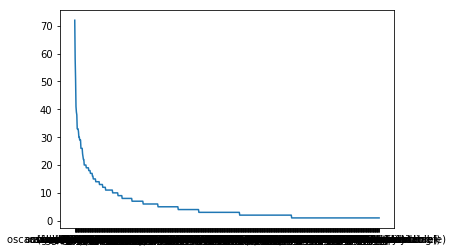

In [30]:
output_result(0,u) 

#### Tag appearance on the second principal component:

action : 92
original : 85
comedy : 81
chase : 59
good action : 58


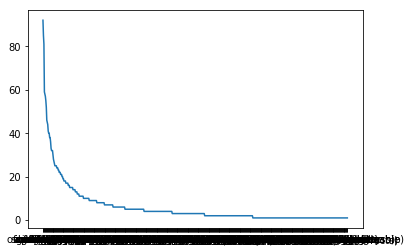

In [31]:
output_result(1,u)  

#### Tag appearance on the third principal component:

imdb top 250 : 96
original : 88
classic : 66
comedy : 61
romantic : 60


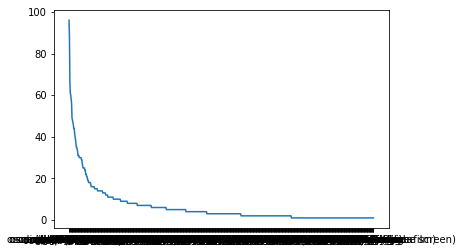

In [32]:
output_result(2,u)  

## 4. Average Movie Score Prediction ##

In this section, I calculated the average score of each movie and saved them as a vector.  
Then I constructed a matrix that contained all the tag scores of each movie.  

Average Movie Rating $y$:

|Movie_index| Average Rating|
|----------:|--------------:|
|0| 3.01|
|1| 2.77|
|...|...|

Movie-Tag Scores Matrix $A$:  

|_ |tag_0| tag_1|tag_2|...|tag_1129|    
| -------------:|--------:| -------------:|--------:|-------------:|--------:|
|Movie_0 |0.025 |0.025 |0.05775|...|0|
|Movie_1 |0 |0 |0.05|...|0|
|Movie_2 |0 |0.02 |0|...|0.15|
|... |... |... |...|...|...|
|Movie_26744 |0.1 |0 |0|...|0|


Note: the data did not contain the tag scores for all the movie. So I did not add the movie into either the matrix or the average movie rating vector, if the movie's tag scores were not available.  
The projection of the movie's tag scores onto the first 2 singular vectors were also plotted to see if the movies are distributed into different clusters.

To better evaluate the model, I split the dataset into training and test dataset by the ratio 4:1.

In [92]:
#construct Matrix A for the least square problem
tag_matrix = []

#record the movie_id to the row_index in A
#movie_index_for_y[movie_id] = row_index
movie_index_for_y = {}

#index indicator
cnt = 0

for movie_raw_id in movie_dict:

    if(movie_raw_id not in movie_tag_score_list):
        #print("movie id ", movie_raw_id, "NOT found in tags_scores_list")
        continue
    
    movie_index_for_y[movie_raw_id] = cnt
    cnt += 1
    
    #construct matrix A
    scores = movie_tag_score_list[movie_raw_id]
    score_vec = np.zeros(len(tag_list ) + 2)
    
    for tag in scores:
        score_vec[tag] = scores[tag]
        
    #offset
    score_vec[-1] = 1
    tag_matrix.append(score_vec)

tag_matrix = np.asarray(tag_matrix)
print("Matrix Shape: ", tag_matrix.shape)

Matrix Shape:  (10369, 1130)


In [93]:
#calculate Matrix y for the least square problem
average_vec = np.zeros(len(movie_index_for_y))

#movie count for the average calculation
movie_id_cnt = {}
for movie_raw_id in movie_dict:
    movie_id_cnt[movie_raw_id] = 0

#sum up
for rating in sample_rating:
    if(rating[1] not in movie_tag_score_list):
        continue
        
    index = movie_index_for_y[int(rating[1])]
    average_vec[index] += rating[2]
    movie_id_cnt[rating[1]] += 1

#take the average
for i in range(len(average_vec)):
    index = list(movie_index_for_y.keys())[list(movie_index_for_y.values()).index(i)]
    average_vec[i] /= movie_id_cnt[index]
print("Average Vector Shape: ", average_vec.shape)

Average Vector Shape:  (10369,)


In [94]:
start_time = time.time()

tag_matrix_T = tag_matrix.T
#remove mean
mean = tag_matrix_T.mean(axis = 1)
tag_matrix_T_zeroM = tag_matrix_T - mean[:, np.newaxis]

xtag_proj = []
ytag_proj = []


u, s, vt = np.linalg.svd(tag_matrix_T_zeroM)
u_x = u[:, 0]
u_y = u[:, 1]
#print(u_x.T @ sp_matrix_zero.getcol(0).toarray())
#iterate through person
for i in range(tag_matrix_T.shape[1]):
    arr = tag_matrix_T_zeroM[:, i]
    x_temp = u_x.T @ arr
    y_temp = u_y.T @ arr
    xtag_proj.append(x_temp) 
    ytag_proj.append(y_temp)

print("Time taken(Sec): ", (time.time() - start_time))

Time taken(Sec):  3.3041269779205322


Text(0.5, 1.0, 'Data projection on first 2 Singular Vectors')

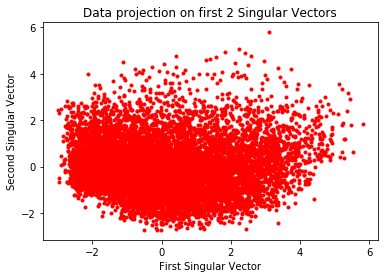

In [95]:
plt.plot(xtag_proj, ytag_proj, '.r')
plt.xlabel("First Singular Vector")
plt.ylabel("Second Singular Vector")
plt.title("Data projection on first 2 Singular Vectors")

In [96]:
#split the data by 4:1 into Train:Test
index_bound = int(average_vec.size * 4/5)

A_train = tag_matrix[:index_bound]
print("Train X size:", A_train.shape)
y_train = average_vec[:index_bound]
print("Train Y size:", y_train.shape)

A_test = tag_matrix[index_bound:]
y_test = average_vec[index_bound:]
print("Test X size:", A_test.shape)
print("Test Y size:", y_test.shape)

Train X size: (8295, 1130)
Train Y size: (8295,)
Test X size: (2074, 1130)
Test Y size: (2074,)


### 4.A Least Square Fit###

Prediction Formula: $$ y = Aw $$  
Least-Square Solution:
$$ w = arg(min_w ||y - Aw||_2^2) $$  
To solve w:  
$$ w = (A^TA) ^{-1}A^Ty$$
Since $ (A^TA) $ was not invertable:  
$$ w = V \mathbf{\Sigma}^{-1} U^T y $$  
where $V, \mathbf{\Sigma}, U$ were solved from SVD.


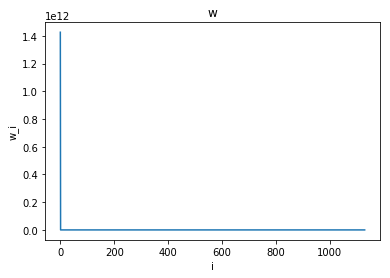

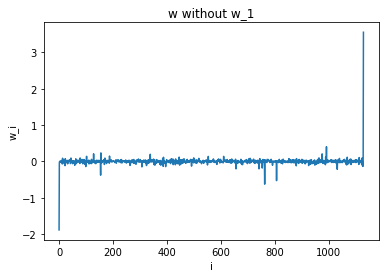

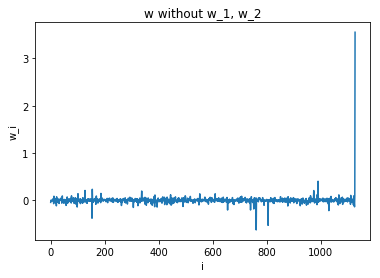

In [97]:
#won't run because singular Matrix couldnt do the inverse
#w = np.linalg.inv(A.transpose() @ A) @ A.tranpose() @ y 

#find the sudo-inverse by svd
u, s, vt = np.linalg.svd(A_train)
u = u[:, 0:s.shape[0]]

w = vt.transpose() @ np.diag(1/s) @ u.transpose() @ y_train

#plotting w with its index
plt.plot(w)
plt.title("w")
plt.xlabel("i")
plt.ylabel("w_i")
plt.show()

plt.plot(w[1:])
plt.title("w without w_1")
plt.xlabel("i")
plt.ylabel("w_i")
plt.show()

plt.plot(w[2:])
plt.title("w without w_1, w_2")
plt.xlabel("i")
plt.ylabel("w_i")
plt.show()

In [98]:
def cal_err(y_new, y_test):
    if(len(y_new) != len(y_test)):
        print("ERROR: two set are not equal in size! ")
        return
    err = 0
    for i in range(len(y_new)):
        #err += y_new[i] * y_new[i] - y_test[i] * y_test[i]
        err += abs(y_new[i] - y_test[i])
        #print(abs(y_new[i] - y_test[i]))
    
    #err /= len(y_test)
    return err

In [99]:
#Performance on the Test Set
y_new = A_test @ w
err = cal_err(y_new, y_test)
print("1-Norm Error:" , err)
print("Average err on each prediction: ", err/ len(y_test))
err_ls = err/ len(y_test)

1-Norm Error: 183.49823369523213
Average err on each prediction:  0.08847552251457673


### 4.B Least Square with Ridge Regression ###

Prediction Formula: $$ y = Aw $$  
Least-Square Solution:
$$ w = arg(min_w ||y - Aw||_2^2 + \mathbf{\lambda}||w||_2^2) $$  
To solve w:   
$$ w = V ( \mathbf{\Sigma}^2 + \mathbf{\lambda}I) ^{-1} \mathbf{\Sigma} U^T y $$  
where $V, \mathbf{\Sigma}, U$ were solved from SVD, and $\mathbf{\lambda}$ was decided by Cross-Validation.


#### Step 1: Pick $\mathbf{\lambda}$ by cross-valid ###

In [101]:
sp = 8 #split number

A_cross_set = np.array_split(A_train, sp)
y_cross_set = np.array_split(y_train, sp)

lambd_test_set = [0.0001,.001, .01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 2, 3, 10]
err_ttl_set = []

for lambd_test in lambd_test_set:
    err_ttl = 0
    start_time = time.time()
    #assume A_train_set and y_train_set match
    for hold_index in range(sp):
        A_eval = A_cross_set[hold_index]
        y_eval = y_cross_set[hold_index]
        A_train_set = np.delete(A_cross_set, hold_index, 0)
        y_train_set = np.delete(y_cross_set, hold_index, 0)

        A_train_ready = np.concatenate(A_train_set)
        y_train_ready = np.concatenate(y_train_set)

        u, s, vt = np.linalg.svd(A_train_ready)
        u = u[:, 0:s.shape[0]]

        w = vt.transpose() @ np.diag(1/(s * s + lambd_test) * s) @ u.transpose() @ y_train_ready

        y_pred = A_eval @ w
        #diff = y_pred - y_eval
        err = cal_err(y_pred, y_eval)
        err_ttl += err

    err_ttl_set.append(err_ttl)

print("The minimum value: ", min(err_ttl_set))
index = err_ttl_set.index( min(err_ttl_set))
print("The lambda at this value: ", lambd_test_set[index])
lambd = lambd_test_set[index]

The minimum value:  454.68555385945274
The lambda at this value:  0.3


Text(0, 0.5, '1-Norm Loss')

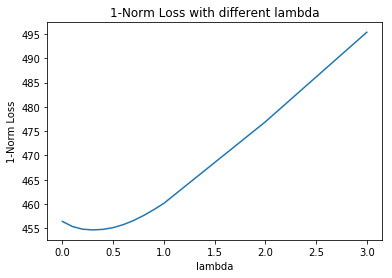

In [102]:
plt.plot(lambd_test_set[:-1], err_ttl_set[:-1])
plt.title("1-Norm Loss with different lambda")
plt.xlabel("lambda")
plt.ylabel("1-Norm Loss")

#### Step 2: Training w with picked  $\mathbf{\lambda}$####

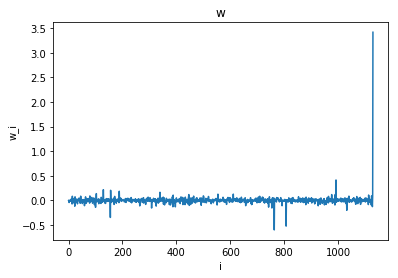

In [103]:
u, s, vt = np.linalg.svd(A_train)
u = u[:, 0:s.shape[0]]
w = vt.transpose() @ np.diag(1/(s * s + lambd) * s) @ u.transpose() @ y_train

plt.plot(w)
plt.title("w")
plt.xlabel("i")
plt.ylabel("w_i")
plt.show()

#### Step 3. Test

In [104]:
y_new = A_test @ w
err = cal_err(y_new, y_test)
print("1-Norm Error:" , err)
print("Average error on each prediction: ", err/ len(y_test))
err_l2r = err/ len(y_test)

1-Norm Error: 183.64329156607891
Average error on each prediction:  0.08854546362877479


### 4.C Least Square with Truncated SVD###
Prediction Formula: $$ y = Aw $$  
To solve w:   
$$ w = \sum_{i = 1}^{r}\frac{1}{\sigma_i} v_i {u_i}^T y $$  

where $v, \mathbf{\sigma}, u$ were solved from SVD, and $r$ was decided by Cross-Validation.


#### Step 1: Pick $r$ by Cross-Validation ####

In [106]:
sp = 8 #split number

A_cross_set = np.array_split(A_train, sp)
y_cross_set = np.array_split(y_train, sp)

r_test_set = []
for i in range(5,10):
    r_test_set.append((i + 1) * 100)
for i in range(1,12, 2):
    r_test_set.append((i+100) * 10)
for i in range(10):
    r_test_set.append(1120 + i)
r_test_set.append(1130)
print(r_test_set)


err_ttl_set = []

for r_test in r_test_set:
    err_ttl = 0
    start_time = time.time()
    #assume A_train_set and y_train_set match
    for hold_index in range(sp):
        A_eval = A_cross_set[hold_index]
        y_eval = y_cross_set[hold_index]
        A_train_set = np.delete(A_cross_set, hold_index, 0)
        y_train_set = np.delete(y_cross_set, hold_index, 0)

        A_train_ready = np.concatenate(A_train_set)
        y_train_ready = np.concatenate(y_train_set)

        u, s, vt = np.linalg.svd(A_train_ready)
        u = u[:, 0:s.shape[0]]

        w = vt.transpose()[:,:r_test] @ np.diag(1/s[:r_test]) @ u.transpose()[:r_test,:] @ y_train_ready

        y_pred = A_eval @ w
        #diff = y_pred - y_eval
        err = cal_err(y_pred, y_eval)
        err_ttl += err

    err_ttl_set.append(err_ttl)
    
print("The minimum value: ", min(err_ttl_set))
index = err_ttl_set.index( min(err_ttl_set))
print("The r at this value: ", r_test_set[index])
r = r_test_set[index]

[600, 700, 800, 900, 1000, 1010, 1030, 1050, 1070, 1090, 1110, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130]
The minimum value:  456.4636248990777
The r at this value:  1128


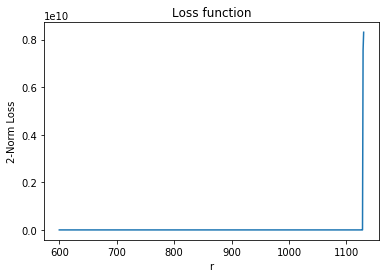

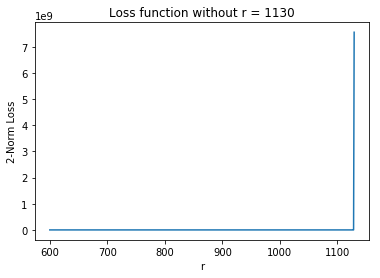

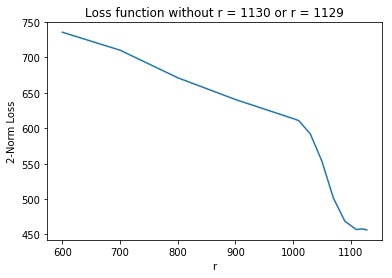

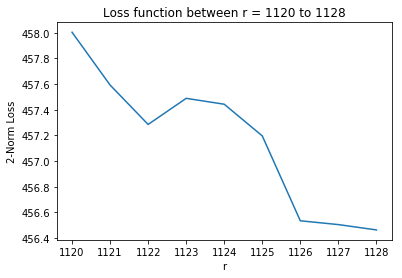

In [107]:
#print( err_ttl_set)
plt.plot(r_test_set, err_ttl_set)
plt.title("Loss function")
plt.xlabel("r")
plt.ylabel("2-Norm Loss")
plt.show()

plt.plot(r_test_set[:-1], err_ttl_set[:-1])
plt.title("Loss function without r = 1130")
plt.xlabel("r")
plt.ylabel("2-Norm Loss")
plt.show()

plt.plot(r_test_set[:-2], err_ttl_set[:-2])
plt.title("Loss function without r = 1130 or r = 1129")
plt.xlabel("r")
plt.ylabel("2-Norm Loss")
plt.show()

plt.plot(r_test_set[11:-2], err_ttl_set[11:-2])
plt.title("Loss function between r = 1120 to 1128")
plt.xlabel("r")
plt.ylabel("2-Norm Loss")
plt.show()

#### Step 2: Training with picked $r$###

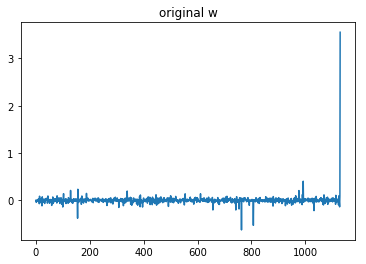

In [108]:
u, s, vt = np.linalg.svd(A_train)
u = u[:, 0:s.shape[0]]
w = vt.transpose()[:,:r] @ np.diag(1/s[:r]) @ u.transpose()[:r,:] @ y_train

plt.plot(w)
plt.title("original w")
plt.show()

#### Step 3: Test

In [109]:
y_new = A_test @ w
err = cal_err(y_new, y_test)
print("1-Norm Error:" , err)
print("Average error on each prediction: ", err/ len(y_test))
err_tr = err/ len(y_test)

1-Norm Error: 183.4776538953612
Average error on each prediction:  0.0884655997566833


## 5. Single User's Movie Rating Prediction

In this section, the user's movie rating was predicted by the same user's past rating record.  
This was done by fitting a regression between the user's past rating score and the left singular vectors $U$ from the movie-user rating matrix.  
The reason behind this was that we could consider the left singular vectors as a set of user's taste patterns on each of the movies. By fitting the user's past scores into the taste patterns, we could find the user's rating habit, which could lead to the prediction of new movies.  
Since the user did not rate all movies, only the movie that the user rated would be put into the Tastes pattern matrix.

Below were the data structures that we need for this section.

User P's Movie Rating $y$:

|Movie_index| P's Rating|
|----------:|--------------:|
|0| 3.5|
|1| 2.0|
|3| 5.0|
|134| 1.0|
|...|...|

Tastes pattern Matrix $A$ (modified $U$):  

|_ |taste_0| taste_1|...|tag_n|    
| -------------:|--------:|--------:|-------------:|--------:|
|Movie_0 |0.xx |0.xx |...|0.xx|
|Movie_1 |0.xx |0.xx|...|0.xx|
|Movie_3 |0.xx |0.xx |...|0.xx|
|Movie_134 |0.xx |0.Xx |...|0.xx|
|... |... |... |...|...|


Due to the limit in computation power, only first 100 users were included.
The code below split the user's rating into 2 part for training and testing.
The error was calculated by  
$$Error = \sum_{i:users} (\frac{\sum_{j:tests}|\hat{y}_{ij} - y_{ij}|}{\# tests})\space  /\space  \#users$$

### 5.A Linear Least Square Fit

Prediction Formula: $$ y = Aw $$  
Least-Square Solution:
$$ w = arg(min_w ||y - Aw||_2^2 + ||w||_2^2) $$  
To solve w:  
$$ w = (A^TA + \lambda I) ^{-1}A^Ty$$


In [145]:
u, s, vt = svds(sp_matrix, k = 100)
print("Shape of tastes pattern matrix: ", u.shape)
users_amt = 100

Shape of tastes pattern matrix:  (26744, 100)


In [147]:
err_ttl = []
test_cnt = []
l = 0.007
for user_index in range(users_amt):
        user_rating = sp_matrix.getcol(user_index)
        nzero_index = user_rating.nonzero() #find the index of non_zero elements
        non_zero_rating = np.asarray([user_rating[i, 0] for i in nzero_index[0]])

        u_partial = np.asarray([u[i] for i in nzero_index[0]])
        #print(u_partial.shape)

        index_bound = int(u_partial.shape[0] * 4/5)
        A_train = u_partial[: index_bound, :]
        y_train = non_zero_rating[: index_bound]

        A_test = u_partial[index_bound:, :]
        y_test = non_zero_rating[index_bound:]
        
        w = np.linalg.inv(A_train.T @ A_train + l * np.diag(np.ones(A_train.shape[1]))) @ A_train.T @ y_train
        y_pred = A_test @ w
        #print("Average Error on each rating: ", sum(abs(y_pred - y_test)) / y_test.shape[0])
        
        err_ttl.append(sum(abs(y_pred - y_test)))
        test_cnt.append(y_test.shape[0])

In [148]:
err = np.asarray(err_ttl)
test = np.asarray(test_cnt)
#print(err/ test)
#print(len(err))
print("Average 1-Norm error on prediction: ", sum(err/ test) / users_amt)

Average 1-Norm error on prediction:  1.8755938161539174


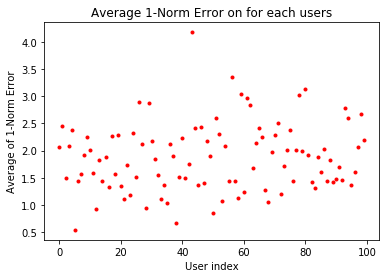

In [149]:
plt.plot(range(users_amt), err/test, ".r")
plt.title("Average 1-Norm Error on for each users")
plt.xlabel("User index")
plt.ylabel("Average of 1-Norm Error")
err_5ls =  err/test

### 5.B High Dimension Least Square Fit with L2 regularization

High dimension Regression was calculated by Guassian Kernel method shown below:
$$ y = \sum_{i = 1}^{N} \alpha_i K(x, x_i) $$
where $N$ was the number of past movie records the user had.

Guassian Kernel K was defined as:
$$ K(u,v) = \exp\{\frac{-||u - v|| ^2_2}{2\sigma^2}\} $$

And $\alpha_i$ was solved by:
$$ \alpha = (\kappa  + \lambda I)^{-1} d $$

where $\kappa$ was defined as:
$$ \kappa = \Phi\Phi^T$$
$$ [\kappa]_{ij} =  \phi^T(x^i)\phi^T(x^j) = K(x^i, x^j)$$

In [117]:
def Guassian_kernal(u, v, thegma = 1):
    a = sum((u - v)**2 * -1 / 2 / thegma**2)
    return math.exp(a)

In [118]:
u, s, vt = svds(sp_matrix, k = 100)
l = 0.007
start_time = time.time()
err_ttl = []
test_cnt = []
for user_index in range(users_amt):
    #user_rating = sp_matrix.getcol(random.randint(0, len(user_dict) - 1))
    user_rating = sp_matrix.getcol(user_index)
    nzero_index = user_rating.nonzero() #find the index of non_zero elements
    non_zero_rating = np.asarray([user_rating[i, 0] for i in nzero_index[0]])

    u_partial = np.asarray([u[i] for i in nzero_index[0]])

    index_bound = int(u_partial.shape[0] * 4/5)
    A_train = u_partial[: index_bound, :]
    y_train = non_zero_rating[: index_bound]

    A_test = u_partial[index_bound:, :]
    y_test = non_zero_rating[index_bound:]

    K_matrix = np.zeros((A_train.shape[0],A_train.shape[0]) )
    for i in range(K_matrix.shape[0]):
        for j in range(K_matrix.shape[1]):
            K_matrix[i,j] = Guassian_kernal(A_train[i,:], A_train[j,:])

    I = np.diag(l * np.ones(K_matrix.shape[0]))
    alpha = np.linalg.inv(K_matrix + I) @ y_train

    y_pred = np.zeros(y_test.shape[0])
    for row in range(y_test.shape[0]):
        y_pred[row] = sum(alpha[i] * Guassian_kernal(A_test[row, :], A_train[i, :]) for i in range(K_matrix.shape[0]))

    err_ttl.append(sum(abs(y_pred - y_test)))
    test_cnt.append(y_test.shape[0])
    #if(user_index % 10 == 9):
        #print(user_index, ": Time taken: ", (time.time() - start_time))

record_time = time.time() - start_time

In [119]:
err = np.asarray(err_ttl)
test = np.asarray(test_cnt)
#print(err/ test)
print("Average 1-Norm error on prediction: ", sum(err/ test) / users_amt)

Average 1-Norm error on prediction:  0.7511311097902166


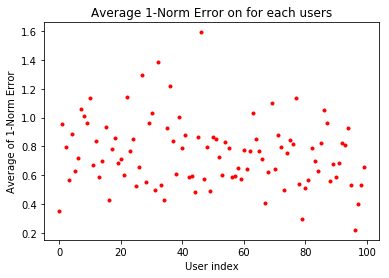

In [120]:
plt.plot(range(users_amt), err/test, ".r")
plt.title("Average 1-Norm Error on for each users")
plt.xlabel("User index")
plt.ylabel("Average of 1-Norm Error")
err_5hd =  err/test

In [143]:
print("Hours needed to predict all user's rating: ", record_time * len(user_dict) / users_amt / 3600, "h")

Hours needed to predict all user's rating:  32.980444131471714 h


## 6. Discussion

### 6.A Average Rating Prediction
Three methods were implemented in total to predict the average movie rating based on the movie-tag matrix.  
They were Least-Square(LS) regression, LS with Ridge Regularization, and LS with Truncated SVD Regularization.  
Their test 1-Norm average error on each movie were shown below.

Least-Square(LS) regression:  0.08847552251457673
LS with Ridge Regularization:  0.08854546362877479
LS with Truncated SVD Regularization:  0.0884655997566833


Text(0, 0.5, 'log(error)')

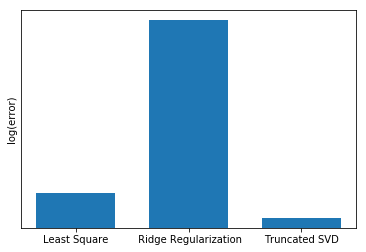

In [128]:
print("Least-Square(LS) regression: ", err_ls)
print("LS with Ridge Regularization: ", err_l2r)
print("LS with Truncated SVD Regularization: ", err_tr)
plt.bar(["Least Square", " Ridge Regularization", "Truncated SVD"], [err_ls,err_l2r,err_tr] ,width=0.7, log = True);
plt.ylabel("log(error)")

### 6.B User's Rating Prediction
Two mothods were implemented to predict the movie rating score on a single user.  
They are Linear Regression and High Dimension Regression.  
Their 1-Norm average error on each person's each rating were shown below.  

Linear regression:  1.8755938161539174
Hign Dimension regression:  0.7511311097902166


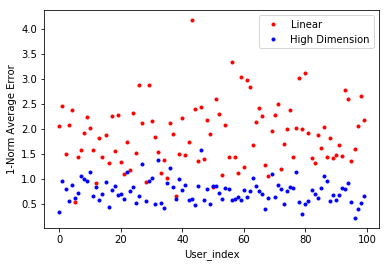

In [150]:
print("Linear regression: ", sum(err_5ls) / users_amt)
print("Hign Dimension regression: ", sum(err_5hd) / users_amt)
plt.plot(range(users_amt), err_5ls, ".r", label = "Linear")
plt.plot(range(users_amt), err_5hd, ".b", label = "High Dimension")
plt.legend()
plt.xlabel("User_index")
plt.ylabel("1-Norm Average Error")
plt.show()

## 7. Conclusion

Based on the dataset of 20M ratings and 11.7K taggings, this project successfully predicted the movie's average rating and user's single movie rating with an acceptable error.

The average movie rating could be predicted with the error less than 0.09.   
The best method for this was Linear Least-Square Regression with Truncated SVD Regularization.  

The single movie rating from a specific user could be predicted with error less than 0.8.  
The best method for this was High Dimension Regression with L2 Regularization. 